In [1]:
from torch import optim
import torch.utils.data as data
from setting_model import *
import numpy as np
import os

CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Model instantiation
# forward_model = model
# forward_model = FC_Net_2D().to(device)

iteration = 0
interval = 100
batch_size = 5
lr = 0.0005
epoch = 5000
iter_num = []
losses = {'err_train': [], 'err_test': [], 'loss_train': [], 'loss_test': []}

In [3]:
# Gets the relevant file path
data_root = os.getcwd()

train_trajectory_path = os.path.join(data_root, "Train_Data_Fig", "trajectory_292_662.csv")
assert os.path.exists(train_trajectory_path), "{} path does not exist.".format(train_trajectory_path)

test_trajectory_path = os.path.join(data_root, "Train_Data_Fig", "trajectory_33_662.csv")
assert os.path.exists(test_trajectory_path), "{} path does not exist.".format(test_trajectory_path)

# Save the updated weights file
#save_dir = os.path.join(data_root, "weight_optim")
#assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

In [4]:
# Loader Data
train_numpy = np.loadtxt(train_trajectory_path, delimiter=",")
train_input = torch.FloatTensor(train_numpy[:, 660:662]).to(device)
train_label = torch.FloatTensor(train_numpy[:, 0:60]).to(device)
train_label = train_label*1e6
train_input[:, 660:662] = train_input[:, 660:662]*10              # 数量级保持一致
train_dataset = data.TensorDataset(train_input, train_label)
data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    # 提取训练数据集并加载

test_numpy = np.loadtxt(test_trajectory_path, delimiter=",")
test_input = torch.FloatTensor(test_numpy[:, 660:662]).to(device)
test_label = torch.FloatTensor(test_numpy[:, 0:60]).to(device)                               # 提取测试数据集
test_label = test_label*1e6
test_input[:, 660:662] = test_input[:, 660:662]*10                # 数量级保持一致

In [5]:
train_numpy.shape

(292, 662)

In [6]:
class FC_Net_2_60(nn.Module):
    def __init__(self):
        super(FC_Net_2_60, self).__init__()
        self.layer1 = nn.Linear(2, 128)                             # features=9       
        self.layer2 = nn.Linear(128, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 60)                   
        self.activation_1 = nn.LeakyReLU()
        self.activation_2 = nn.ReLU()

    def forward(self, inputs):
        x1 = self.activation_1(self.layer1(inputs))
        x2 = self.activation_1(self.layer2(x1))
        x3 = self.activation_1(self.layer3(x2))
        x4 = self.activation_1(self.layer4(x3))
        x5 = self.layer5(x4)
        return x5
    
forward_model = FC_Net_2_60().to(device)

In [7]:
a = torch.ones((10, 2)).to(device)
b = forward_model(a)
b.shape

torch.Size([10, 60])

In [8]:
# Training process
def train():
    optimizer = optim.Adam(forward_model.parameters(), lr=lr)    # 添加正则化函数，避免过拟合
    criterion = nn.MSELoss(reduction='mean')

    for t in range(epoch):
        for step, item in enumerate(data_loader):
            # train
            train_input, train_label = item
            train_predict = forward_model(train_input)
            loss_train = criterion(train_predict, train_label)
            
            global iteration                      # 声明全局变量， 不声明全局变量会报错
            if iteration % interval == 0:
                # test
                test_predict = forward_model(test_input)
                loss_test = criterion(test_predict, test_label)
                losses['loss_train'].append(loss_train.cpu().detach().numpy())
                losses['loss_test'].append(loss_test.cpu().detach().numpy())

                # compute and print the absolute error
                train_out = train_predict - train_label
                train_error = np.abs(train_out.cpu().detach().numpy()).mean()
                test_out = test_predict - test_label
                test_error = np.abs(test_out.cpu().detach().numpy()).mean()
                losses['err_train'].append(train_error)
                losses['err_test'].append(test_error)
                
                # 需要补充判断当Train_loss和Test_loss的最小时，保存此时的训练模型

                print('iteration: {}'.format(iteration))
                print('train_loss: {:.4}, test_loss: {:.4}'.
                      format(loss_train, loss_test))
                print('train_error: {:.4}, test_error: {:.4}'.
                      format(train_error, test_error))

                iter_num.append(iteration)


            # update parameters
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            iteration += 1
            
            

In [9]:
train()

iteration: 0
train_loss: 0.5717, test_loss: 0.3995
train_error: 0.6141, test_error: 0.5059
iteration: 100
train_loss: 0.5395, test_loss: 0.3323
train_error: 0.556, test_error: 0.4569
iteration: 200
train_loss: 0.2322, test_loss: 0.2848
train_error: 0.3678, test_error: 0.4182
iteration: 300
train_loss: 0.2238, test_loss: 0.2544
train_error: 0.3374, test_error: 0.375
iteration: 400
train_loss: 0.2295, test_loss: 0.2322
train_error: 0.3547, test_error: 0.3621
iteration: 500
train_loss: 0.1785, test_loss: 0.1774
train_error: 0.3183, test_error: 0.3142
iteration: 600
train_loss: 0.07643, test_loss: 0.1919
train_error: 0.2076, test_error: 0.3109
iteration: 700
train_loss: 0.1461, test_loss: 0.1608
train_error: 0.2642, test_error: 0.2798
iteration: 800
train_loss: 0.05919, test_loss: 0.1503
train_error: 0.1893, test_error: 0.2803
iteration: 900
train_loss: 0.06988, test_loss: 0.1274
train_error: 0.1772, test_error: 0.2543
iteration: 1000
train_loss: 0.04739, test_loss: 0.1543
train_error: 0.1

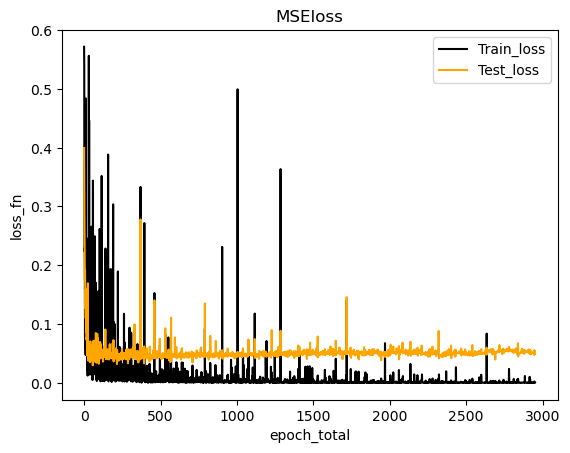

In [10]:
# 过拟合
# MSEloss curve
Len = len(losses['loss_train'])
epoch_total = np.linspace(0, Len, Len)
plt.title('MSEloss')
plt.plot(epoch_total, losses['loss_train'],color="black", label='Train_loss')
plt.plot(epoch_total, losses['loss_test'],color="orange", label='Test_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch_total')
plt.ylabel('loss_fn')
plt.show()

tensor([[0.0100, 0.0800]], device='cuda:0')


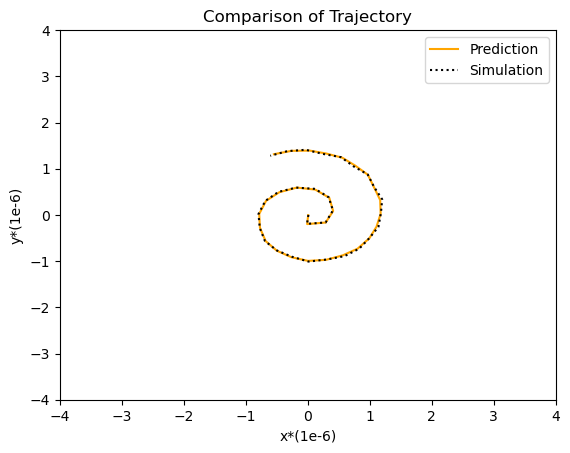

In [15]:
# plot_train_data
c =20                    # 82
valid_input = train_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 60)               
valid_label = train_label[c].cpu().detach().numpy().reshape(1, 60)                                    
valid_predict = valid_predict.reshape(60,)
valid_label = valid_label.reshape(60,)
print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:30], valid_predict[30:60], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:30], valid_label[30:60], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

tensor([[0.0200, 0.4000]], device='cuda:0')


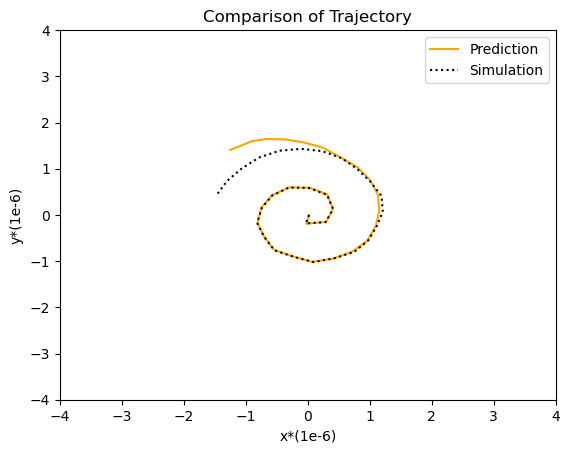

In [25]:
# plot_train_data
c = 7               # 10
valid_input = test_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 60)               
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 60)                                    
valid_predict = valid_predict.reshape(60,)
valid_label = valid_label.reshape(60,)
print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:30], valid_predict[30:60], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:30], valid_label[30:60], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

In [13]:
# 保存更新后的模型
"""
# Save the updated weights file
save_dir = os.path.join(data_root, "weight_optim")
assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

torch.save(forward_model.state_dict(),save_dir + '\\forward_phase1_linear.pt')"""

'\n# Save the updated weights file\nsave_dir = os.path.join(data_root, "weight_optim")\nassert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)\n\ntorch.save(forward_model.state_dict(),save_dir + \'\\forward_phase1_linear.pt\')'

In [14]:
"""
# 保存MSEloss数据
A = np.zeros((4200, 3)) 
loss_train = losses['loss_train']
loss_test = losses['loss_test']

# list转化为ndarray
epoch_total = epoch_total.reshape(4200,)                       # 第0列训练次数为x数据
loss_train = np.array(loss_train).reshape(4200,)            
loss_test = np.array(loss_test).reshape(4200,)                 # 第1，2列为训练和测试损失
epoch_total.shape, loss_train.shape, loss_test.shape

# 保存数据
A[:, 0] = epoch_total
A[:, 1] = loss_train
A[:, 2] = loss_test
filename1 = os.path.join(data_root, "trajectory_test_phase1.csv")
np.savetxt(filename1, A, delimiter=',')"""

'\n# 保存MSEloss数据\nA = np.zeros((4200, 3)) \nloss_train = losses[\'loss_train\']\nloss_test = losses[\'loss_test\']\n\n# list转化为ndarray\nepoch_total = epoch_total.reshape(4200,)                       # 第0列训练次数为x数据\nloss_train = np.array(loss_train).reshape(4200,)            \nloss_test = np.array(loss_test).reshape(4200,)                 # 第1，2列为训练和测试损失\nepoch_total.shape, loss_train.shape, loss_test.shape\n\n# 保存数据\nA[:, 0] = epoch_total\nA[:, 1] = loss_train\nA[:, 2] = loss_test\nfilename1 = os.path.join(data_root, "trajectory_test_phase1.csv")\nnp.savetxt(filename1, A, delimiter=\',\')'